# Multilayer Perceptron for Cell Classification

This notebook will...

* Apply single cell RNA sequence (scRNA-seq) data for cell subclass prediction

* Demonstrate use of an MLP for multiclass classification

Preprocessed RNA sequence data is published by:

* [Abdelaal, T.; Michielsen, L.; Cats, D.; Hoogduin, D.; Mei, H.; Reinders, M. J. T.; Mahfouz, A. A Comparison of Automatic Cell Identification Methods for Single-Cell RNA Sequencing Data. Genome Biology 2019, 20 (1), 194.](https://doi.org/10.1186/s13059-019-1795-z)



## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## Load cell labels and scRNA seq counts

In [2]:
# Select labels
all_cell_labels = pd.read_csv("data/Labels.csv", usecols=[1])
select_subclasses = ["Vip", "Lamp5", "Sst", "L6 CT", "L2/3 IT", "Pvalb"]
inds = np.where(
    [i in select_subclasses for i in all_cell_labels.values]
)[0]
labels = all_cell_labels.values[inds].flatten()

print("Cell subclass labels: \n")
print(labels)

Cell subclass labels: 

['Vip' 'Lamp5' 'Lamp5' ... 'Sst' 'Pvalb' 'Sst']


In [3]:
num_genes = 1000    # Number of genes to consider during classification
# Load select gene IDs
gene_IDs = pd.read_csv("data/subset_filtered_mouse_allen_brain_data.csv", usecols=np.arange(1, num_genes+1, 1), nrows=1).columns.values

print("Example Gene IDs: \n")
print(gene_IDs[:12])

Example Gene IDs: 

['0610005C13Rik' '0610006L08Rik' '0610007P14Rik' '0610009B22Rik'
 '0610009E02Rik' '0610009L18Rik' '0610009O20Rik' '0610010B08Rik'
 '0610010F05Rik' '0610010K14Rik' '0610011F06Rik' '0610012G03Rik']


In [4]:
# Load Transcript Counts for Samples of select cell subclass
scRNAseq_counts = pd.read_csv("data/subset_filtered_mouse_allen_brain_data.csv", usecols=np.arange(1, num_genes+1, 1)).iloc[inds, :]
scRNAseq_counts.head()

,0610005C13Rik,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,0610010K14Rik,...,4930412E21Rik,4930412L05Rik,4930412O13Rik,4930413E15Rik,4930413F20Rik,4930413G21Rik,4930413M19Rik,4930414F18Rik,4930414L22Rik,4930414N06Rik
0,0,0,79,145,1,46,123,0,0,33,...,0,0,0,0,0,5,0,0,55,0
1,0,0,123,178,26,23,2,0,337,318,...,0,0,0,0,0,3,0,0,66,0
2,0,0,89,69,0,13,29,0,112,76,...,0,0,0,0,0,4,0,0,104,0
3,0,0,115,0,0,0,50,0,35,18,...,0,0,0,0,0,7,0,0,41,0
4,0,0,402,208,0,42,0,0,0,42,...,0,0,0,0,0,1,0,0,57,0


## Visualize gene expression levels by cell type

For purposes of demonstration, limit visualization to top 30 genes

In [5]:
genes_vis = 20
scRNAseq_counts_vis = scRNAseq_counts.iloc[:, :genes_vis]
scRNAseq_counts_vis.head()

,0610005C13Rik,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610031O16Rik,0610037L13Rik,0610038B21Rik,0610039H22Rik,0610039K10Rik,0610040B10Rik
0,0,0,79,145,1,46,123,0,0,33,150,575,0,16,0,110,0,0,0,0
1,0,0,123,178,26,23,2,0,337,318,61,318,0,10,0,383,0,2,0,88
2,0,0,89,69,0,13,29,0,112,76,79,170,0,0,0,160,0,0,0,0
3,0,0,115,0,0,0,50,0,35,18,0,193,0,90,0,189,0,0,0,112
4,0,0,402,208,0,42,0,0,0,42,0,23,0,71,0,114,0,0,0,0


In [6]:
avg_exp = []
for subclass in select_subclasses:
    inds = [i for i in range(len(labels)) if labels[i] == subclass]
    avg_expression_levels = np.nanmean(scRNAseq_counts_vis.iloc[inds, :].values, axis=0)
    avg_exp.append(avg_expression_levels)
avg_exp = np.array(avg_exp)

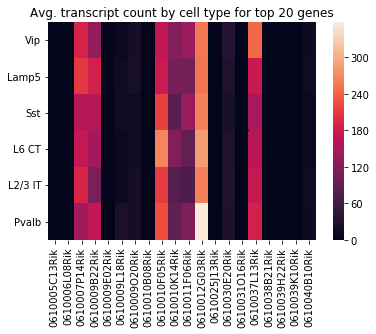

In [7]:
# This cell takes a minute to run...
plt.figure()
sb.heatmap(
    avg_exp,
    xticklabels = scRNAseq_counts_vis.columns,
    yticklabels = select_subclasses
)
plt.yticks(np.arange(6)+0.5,rotation=0, fontsize="10", va="center")
plt.title("Avg. transcript count by cell type for top 20 genes")
plt.show()

## Train the MLP classifier

In [8]:
X_train, X_test, y_train, y_test = train_test_split(scRNAseq_counts.values, labels, test_size=0.2)

mlp_classifier = MLPClassifier(
    activation="logistic",
    max_iter=10000
)

mlp_classifier.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=10000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

## Evaluate classifier performance

In [9]:
y_test_predicted = mlp_classifier.predict(X_test)

print("Actual Labels: \n")
print(y_test)
print("\nPredicted Labels: \n")
print(y_test_predicted)
print("\n\n")
print("\nAccuracy: " + str(mlp_classifier.score(X_test, y_test)) + "\n")
print("Confusion Matrix: \n")
print(confusion_matrix(y_test, y_test_predicted))

Actual Labels: 

['Pvalb' 'Sst' 'Lamp5' ... 'Lamp5' 'L2/3 IT' 'L6 CT']

Predicted Labels: 

['Pvalb' 'Sst' 'Lamp5' ... 'Lamp5' 'L2/3 IT' 'L6 CT']




Accuracy: 0.9561699258260283

Confusion Matrix: 

[[201   1   0   0   0   0]
 [  0 204   0   0   0   0]
 [  0   0 198   0   1   5]
 [  0   0   0 220  20   2]
 [  0   0   0  19 299   3]
 [  0   0  10   2   2 296]]


Using a multilayer perceptron, we are able to classify six cell types with 95% accuracy using their transcriptomes